In [1]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

2022-11-22 08:18:20.320043: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-22 08:18:20.320114: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [3]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [4]:
# Using TPU
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-11-22 08:18:29.855986: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-22 08:18:29.856409: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-22 08:18:29.856448: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 08:18:29.856483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (62b2546606ac): /proc/driver/nvidia/version does not exist
2022-11-22 08:18:29.857544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [5]:
filename1 = 'news_summary.csv'
filename2 = 'news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [6]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
1893,Chhavi Tyagi,"26 Dec 2016,Monday",I don't recall receiving payment from Sahara: ...,http://indiatoday.intoday.in/story/sahara-diar...,After the Congress tweeted a list of Sahara Gr...,Embarrassed by her own party's tweet on Sahara...
1570,Saloni Tandon,"15 Jan 2017,Sunday",B'desh keeper sets record for most catches by ...,http://indiatoday.intoday.in/story/imrul-kayes...,Bangladesh player Imrul Kayes set a world reco...,Imrul Kayes on Sunday became the first substit...
3197,Abhishek Bansal,"29 May 2017,Monday","After defeating Kiwis, Kohli shares picture fr...",http://indiatoday.intoday.in/story/virat-kohli...,Indian captain Virat Kohli has shared a pictur...,The Indian team is enjoying their time in Engl...
2685,Vani Vivek,"06 Jul 2017,Thursday",Several female Tesla employees claim harassmen...,https://www.theguardian.com/technology/2017/ju...,"According to a report by The Guardian, several...",The theme for this year?s International Women?...
1565,Ankush Verma,"16 Jan 2017,Monday",Obama declares January 16 as Religious Freedom...,http://indiatoday.intoday.in/story/president-b...,US President Barack Obama has declared January...,"Continuing a yearly tradition, outgoing US Pre..."


In [7]:
df2.sample(5)

,headlines,text
64077,Pharrell Williams invests in UK-based music st...,UK-based music startup Roli on Wednesday annou...
74510,Indian-origin actress hid in freezer during Ba...,"Laila Rouass, an Indian-origin television actr..."
81223,Honour people who murdered cow killer: Swami P...,A video of Chhattisgarh's Sanskrit Board Chair...
17504,'Googley' doesn't mean 'young': Google in age-...,Refuting the claims made in a lawsuit accusing...
725,"Gambhir, Chhetri among 9 sports personalities ...",As many as nine sports personalities have been...


In [8]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
32135,"PNB denies data breach of 10,000 cardholders",India's second-largest public sector lender Pu...
7936,Juveniles to not be lodged in police lockups i...,"Juvenile offenders, including stone-pelters, w..."
37710,Where's Babu Bhaiya: Arjun Kapoor on pic of Ak...,"Arjun Kapoor, while commenting on Akshay Kumar..."
23233,Biggest load of cow dung: Shastri on reports o...,Team India head coach Ravi Shastri has dismiss...
68211,India will be $6 trillion economy in 10 yrs: M...,According to a report by global brokerage Morg...


In [9]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all cannot expand contractions id think'

In [10]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
74880,over 200 people questioned over delhi mass sui...,more than 200 people have been questioned in c...
47653,four crpf jawans killed by another jawan in ch...,four crpf jawans were killed and another was i...
9298,delhi woman's earlobes get torn as thief pulls...,a 47-year-old woman's earlobes got torn after ...
32509,ensure children not hurt during muharram: bomb...,the bombay high court on monday directed the p...
4959,only 100 firms account for 71% of global emiss...,just 100 companies have been the source of 71%...


In [11]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
64509,"gst network receives 10,000 calls per day, say...","following the gst rollout, the gst network has..."
27609,indian-origin policemans suspected killer arre...,authorities have arrested the suspect who fata...
26610,hindu outfit leader shot dead in broad dayligh...,hindu sangharsh sena district president vipan ...
9078,farmers do shavasana on highway on intl yoga d...,farmers across north india performed the shava...
100583,player wins tournament after initially failing...,world number 59 tennis player o cecchinato won...


In [12]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [13]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [14]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [15]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [16]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
93519,deepika padukone confirms dating ranveer singh...,following announcement iage dates mber actress...
93659,barcelona win st el claasico without messi ron...,uruguayan forward luis suaarez netted hattrick...
85897,diamond ring bought aaa1 sold aaa1 crore,diamond ring sold aa aaa1 crore auction london...
5475,govt releases salary funds delhi university co...,deputy cm manish sisodia ordered release funds...
54330,bjp wins owaisi flee telangana cm,speaking rally pollbound telangana uttar prade...


In [17]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [18]:
#Using a start and end tokens in headlines(summary) to let the learning algorithm know from where 
#the headlines start's and end's.
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

In [19]:
#Again adding tokens ... but different ones.
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [20]:
df.sample(5)

,headlines,text
2154,sostok _START_ police book unknown persons har...,police booked unknown persons allegedly sexual...
47119,sostok _START_ jawan tonsures constable makes ...,police constable allegedly tonsured forced eat...
53075,sostok _START_ tripura governor compares azaan...,tripura governor tathagata roy compared azaan ...
21799,sostok _START_ us qatar sign agreement fightin...,united states qatar tuesday signed agreement c...
4979,sostok _START_ south korea uncovers mn illegal...,south korea uncovered illegal cryptocurrency f...


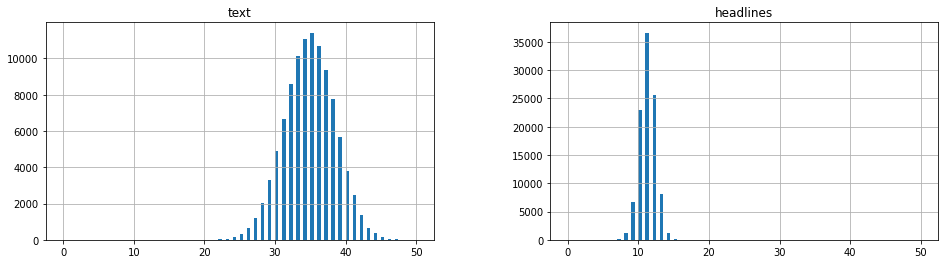

In [21]:
#Finding what should be the maximum length of text and headlines that will be feed or 
#accepted by the learning algorithm.
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [22]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


In [23]:
max_text_len = 42
max_summary_len = 13

In [24]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 100278


,text,summary
12689,teacher couple working private school jammu ka...,sostok _START_ teacher couple sacked school sa...
65254,father manoj kharat arrested cbi pnb fraud cas...,sostok _START_ pnb framed son arrested bank of...
81553,yacht party organised ahead sunburn saw nucley...,sostok _START_ pre yacht party organised ola a...
69212,tesla shareholders tuesday voted proposal remo...,sostok _START_ musk remain tesla chairman prop...
56348,india consumes maximum amount mobile data worl...,sostok _START_ india consumes mobile data per ...


In [25]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [26]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

In [27]:
#Tokenizing text - x
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.35, 'total_coverage': 2.96, 'count': 65254, 'total_count': 99858}


In [28]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [29]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

99859


In [31]:
#Tokenizing headlines(summary) - y
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 69.12, 'total_coverage': 4.79, 'count': 25880, 'total_count': 37440}


In [32]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [33]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37441


In [35]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

In [36]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [37]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '../input/glove6b/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 56460 words (43398 misses)
Found 400000 word vectors.
Converted 27615 words (9825 misses)


In [38]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(99859, 300)
(37441, 300)


In [39]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        
        # Encoder
        # =====================
        
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        
        # Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        
        # Model
        # =====================
        
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [40]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 300)      29957700    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 240), (N 519360      embedding[0][0]                  
______________________________________________________________________________________________

In [41]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [42]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [43]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [44]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 38s 233ms/step - loss: 7.0053 - accuracy: 0.2498 - val_loss: 5.0884 - val_accuracy: 0.4320
Epoch 2/50
89/89 [==============================] - 4s 50ms/step - loss: 5.2004 - accuracy: 0.4184 - val_loss: 4.8967 - val_accuracy: 0.4363
Epoch 3/50
89/89 [==============================] - 4s 50ms/step - loss: 5.0158 - accuracy: 0.4231 - val_loss: 4.7046 - val_accuracy: 0.4407
Epoch 4/50
89/89 [==============================] - 4s 50ms/step - loss: 4.8015 - accuracy: 0.4277 - val_loss: 4.4797 - val_accuracy: 0.4486
Epoch 5/50
89/89 [==============================] - 5s 51ms/step - loss: 4.5615 - accuracy: 0.4351 - val_loss: 4.2952 - val_accuracy: 0.4542
Epoch 6/50
89/89 [==============================] - 5s 51ms/step - loss: 4.3521 - accuracy: 0.4421 - val_loss: 4.1759 - val_accuracy: 0.4591
Epoch 7/50
89/89 [==============================] - 5s 51ms/step - loss: 4.1839 - accuracy: 0.4486 - val_loss: 4.0669 - val_accuracy: 0.4636
Epoch 8/50


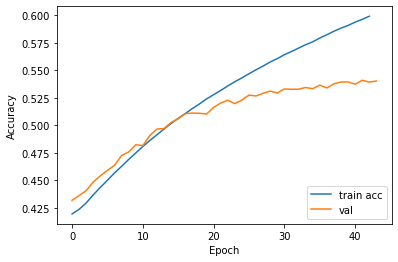

In [45]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

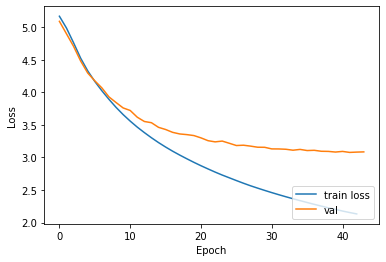

In [46]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [47]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [48]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [49]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [50]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 42, 300)           29957700  
_________________________________________________________________
lstm (LSTM)                  [(None, 42, 240), (None,  519360    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 42, 240), (None,  461760    
Total params: 30,938,820
Trainable params: 981,120
Non-trainable params: 29,957,700
_________________________________________________________________


In [51]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    11232300    input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 240)]        0                                            
____________________________________________________________________________________________

In [52]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [53]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [54]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [55]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [56]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [57]:
model_out=[]
for i in range(0, 15):
    predict_summary=decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    model_out.append(predict_summary)

In [59]:
reference=[]
for i in range(0,15):
    original_summary=seq2summary(y_train_padded[i])
    reference.append(original_summary)

In [60]:
pip install rouge

Note: you may need to restart the kernel to use updated packages.


In [61]:
from rouge import Rouge

In [62]:
rouge = Rouge()

In [63]:
rouge.get_scores(model_out, reference, avg=True)

{'rouge-1': {'r': 0.4698508898508898,
  'p': 0.5562698412698412,
  'f': 0.5054978082354765},
 'rouge-2': {'r': 0.10925925925925925,
  'p': 0.12642857142857142,
  'f': 0.11645191180184716},
 'rouge-l': {'r': 0.45503607503607496,
  'p': 0.5384126984126983,
  'f': 0.48932133764724123}}

In [64]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  somalian jihadist fundamentalist group alshabaab announced ban plastic bags territories controls saying discarded bags pose serious threat wellbeing humans animals alike group also issued immediate ban logging indigenous trees notably alqaeda affiliate carried suicide attacks massacres across east africa 
Original summary:  start jihadists announce ban plastic bags protect humans end 
Predicted summary:   start iran bans plastic bags plastic bags ban end

# 2 News:  iit kanpur monday suspended students three years six students one year freshers alleged ragged forced strip second year btech students students directed vacate hostel rooms allowed resume studies suspension ends iit kanpur deputy director manindra agrawal said 
Original summary:  start iit kanpur suspends students years ragging end 
Predicted summary:   start jnu students suspended ragging ors end

# 3 News:  west hollywood city council us voted unanimously remove us president donald trumps star hollywood walk fa

In [65]:
model_out=[]
for i in range(0, 15):
    predict_summary=decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    model_out.append(predict_summary)

In [66]:
reference=[]
for i in range(0,15):
    original_summary=seq2summary(y_val_padded[i])
    reference.append(original_summary)

In [67]:
rouge = Rouge()

In [68]:
rouge.get_scores(model_out, reference, avg=True)

{'rouge-1': {'r': 0.3821693121693121,
  'p': 0.42899470899470893,
  'f': 0.40084477291546217},
 'rouge-2': {'r': 0.09259259259259259,
  'p': 0.09669312169312169,
  'f': 0.09403133671775593},
 'rouge-l': {'r': 0.3726455026455026,
  'p': 0.41947089947089944,
  'f': 0.3913209633916527}}

In [69]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  pm narendra modi sunday paid tribute indian soldiers fought first world war war india directly involved yet soldiers fought world cause peace said india reiterates commitment towards world peace pledges work atmosphere harmony added 
Original summary:  start pm modi pays tribute indian soldiers fought wwi end 
Predicted summary:   start pm modi pays homage indian soldiers war war end

# 2 News:  western railway ded deploy women ticket examiners coaches mumbaiahmedabad shatabdi express pilot basis sion taken two women checkers employed train trial basis following suspension two male ttes malpractices helping improve revenue collection aaa1 
Original summary:  start mumbai shatabdi allwomen ticket checkers board end 
Predicted summary:   start railways train women apply coaches end

# 3 News:  amazon indias flagship campaign apni connect customers remotest parts country facing copyright issue name apni ravi jains domain registered trade apni going request amazon remove referen